<p><img alt="Colaboratory logo" height="50px" src="https://github.com/INGEOTEC/text_models/raw/master/docs/source/ingeotec.png" align="left" hspace="10px" vspace="0px" /></p>

<h1>Text Models</h1>

### http://github.com/ingeotec

# Installing text_models and helper functions

In [65]:
import numpy as np
from matplotlib import pylab as plt
import pandas as pd
from tqdm import tqdm
import random
from sklearn.decomposition import PCA

In [ ]:
!pip install -U text_models

In [ ]:
# Installing wordcloud
!pip install wordcloud

In [24]:
%pylab inline
def cloud(data):
  from wordcloud import WordCloud
  data = data if isinstance(data, dict) else data.voc
  word_cloud = WordCloud().generate_from_frequencies(data)
  plt.imshow(word_cloud, interpolation='bilinear')
  plt.axis("off")

Populating the interactive namespace from numpy and matplotlib


# Mobility

In [78]:
countries = ["MX", "CA", "SA", "RU"]

In [80]:
from text_models import Mobility, MobilityWeekday
end=dict(year=2020, month=1, day=6)
start=dict(year=2022, month=3, day=13)
mob = Mobility(start, end=end, countries=set(countries))

In [81]:
data = mob.overall(pandas=True)

In [87]:
data

,MX,XX,CA,RU,SA
2019-12-31,4423,132169,2435,88,360
2020-01-01,3665,105908,2073,78,275
2020-01-02,3872,109435,2126,70,278
2020-01-03,4138,115523,2146,84,252
2020-01-04,3895,109429,2043,71,255
...,...,...,...,...,...
2022-03-09,2200,65589,1077,116,1353
2022-03-10,2166,67215,1190,133,1594
2022-03-11,2437,72869,1406,258,1395
2022-03-12,2145,70898,1264,268,1378


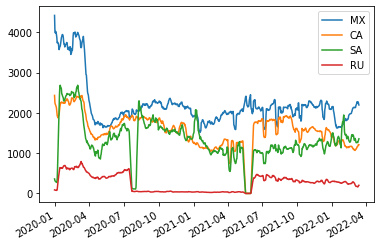

In [88]:
m = data.loc[:, ["MX", "CA", "SA", "RU"]]
m.rolling(7, min_periods=1).mean().plot()

In [84]:
end=dict(year=2020, month=1, day=6)
start=dict(year=2022, month=3, day=13)
mob = MobilityWeekday(start, end=end, countries=set(["MX"]))
d = mob.overall(pandas=True)

In [85]:
def fill(d):
  if d.shape[0] < 7:
    median = np.median(d)
    _ = [median for i in range(7 - d.shape[0])]
    return np.concatenate([d, _])
  return d

d_dict = {c.date(): fill(v.to_numpy())
          for c, v in d.loc[:, "MX"].resample("W")} 

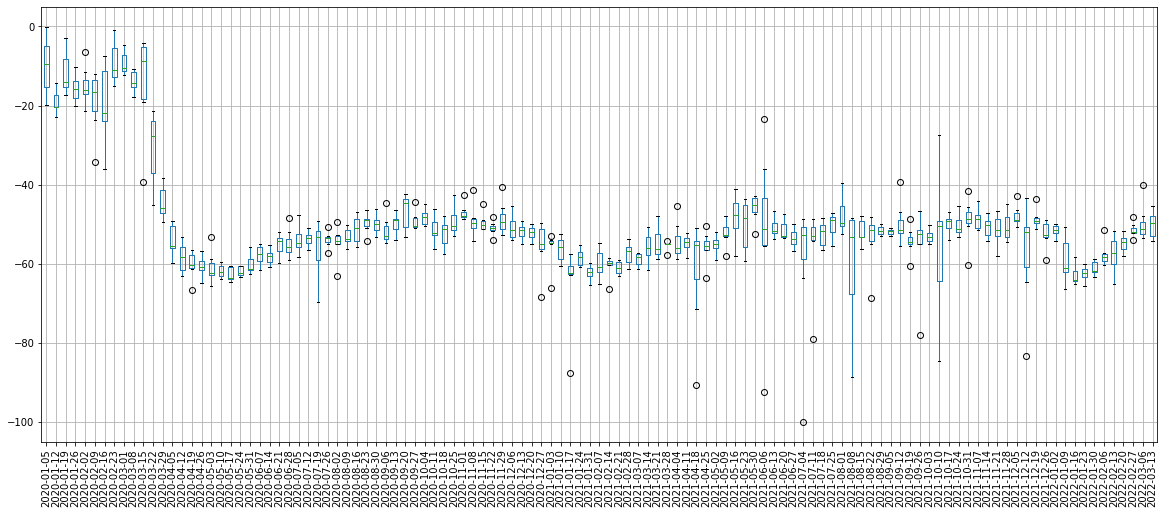

In [89]:
pd.DataFrame(d_dict).boxplot(rot=90, figsize=(20, 8))

# Text

In [49]:
from text_models import Vocabulary

In [91]:
day = dict(year=2020, month=2, day=14)
voc = Vocabulary(day, lang="En",
                 country="US")

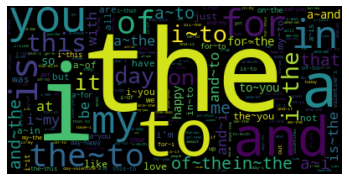

In [92]:
cloud(voc)

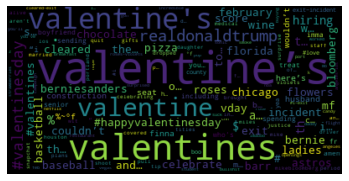

In [93]:
voc.remove(voc.common_words())
#WordCloud does not handle correctly emojis
voc.remove_emojis()
cloud(voc)

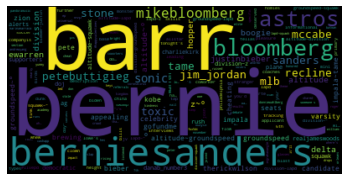

In [94]:
day_words = voc.day_words()
cw = day_words.common_words(quantile=0.90)
voc.remove(cw, bigrams=False)
cloud(voc)

In [100]:
day = dict(year=2020, month=5, day=10)
voc = Vocabulary(day, lang="Es",
                 country="MX")

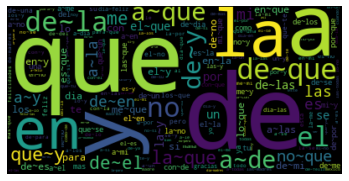

In [101]:
cloud(voc)

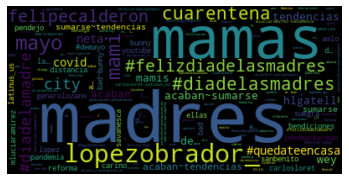

In [102]:
voc.remove(voc.common_words())
#WordCloud does not handle correctly emojis
voc.remove_emojis()
cloud(voc)

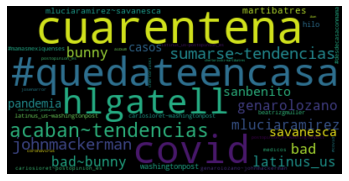

In [103]:
day_words = voc.day_words()
cw = day_words.common_words(quantile=0.90)
voc.remove(cw, bigrams=False)
cloud(voc)

# Earthquake

In [58]:
from text_models import Vocabulary
from text_models.utils import date_range
init = dict(year=2016, month=1, day=1)
end = dict(year=2022, month=3, day=13)
avail = Vocabulary.available_dates
dates = avail(date_range(init, end), n=-1,
              countries=None,
              lang="Es")


In [ ]:

serie = [(dd, Vocabulary(dd, lang="Es")['terremoto']) for dd in tqdm(dates)]
se = pd.Series([x[1] for x in serie],
               index=[x[0] for x in serie])

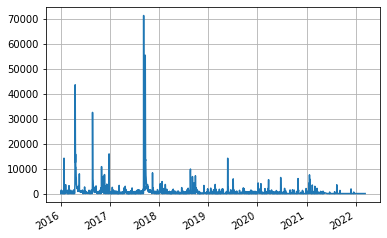

In [95]:
se.plot(grid=True)

In [ ]:
filtro = [Vocabulary(dd, lang="Es") for dd, freq in tqdm(serie) if freq > 20000]

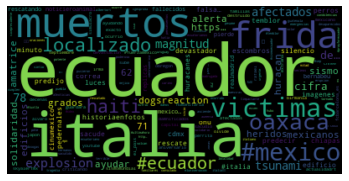

In [96]:
for voc in filtro:
  voc.remove(voc.common_words())
  
keywords = dict()
for data in filtro:
  d = data.co_occurrence("terremoto")
  tot = sum(list(d.values()))
  for k, v in d.items():
    keywords[k] =  max(v / tot, keywords.get(k, 0))
cloud(keywords)

# Similarity between Spanish-speaking Countries

In [63]:
from text_models import Vocabulary
from text_models.utils import date_range

In [64]:
# Number of days
NDAYS = 30
init = dict(year=2019, month=1, day=1)
end = dict(year=2021, month=11, day=1)
dates = date_range(init, end)
random.shuffle(dates)
countries = ['MX', 'CO', 'ES', 'AR',
             'PE', 'VE', 'CL', 'EC',
             'GT', 'CU', 'BO', 'DO',
             'HN', 'PY', 'SV', 'NI',
             'CR', 'PA', 'UY']
avail = Vocabulary.available_dates
dates = avail(dates, n=NDAYS,
              countries=countries,
              lang="Es")

In [ ]:
vocs = [Vocabulary(dates, lang="Es",
                   country=c)
        for c in tqdm(countries)]

In [67]:
_min = min([len(x.voc) for x in vocs])
_min = int(_min * .1)
tokens = [x.voc.most_common(_min) 
          for x in vocs]
tokens = [set(map(lambda x: x[0], i)) 
          for i in tokens]

In [68]:
X = [[len(p & t) / len( p | t)
      for t in tokens] for p in tokens]

In [69]:
X = PCA(n_components=2).fit_transform(X)

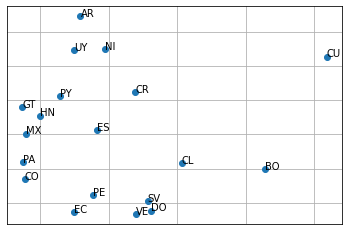

In [99]:
plt.plot(X[:, 0], X[:, 1], "o")
for l, x in zip(countries, X):
  plt.annotate(l, x)
#
plt.grid()
plt.tick_params(axis="both", which="both", bottom=False,
                top=False, left=False, right=False,
                labelbottom=False, labelleft=False)